Step 1: build a surface water network. You can "pickle" this, so it doesn't need to be repeated.

n = swn.SurfaceWaterNetwork.from_lines(gdf.geometry)

n.to_pickle("surface-water-network.pkl")

# then in a later session, skip the above and just do:

n = swn.SurfaceWaterNetwork.from_pickle("surface-water-network.pkl")

Step 2: load a MF6 model, then find the intersections:

sim = flopy.mf6.MFSimulation.load(...)

m = sim.get_model(...)

nm = swn.SwnMf6.from_swn_flopy(n, m)

Most of the results will be in the nm.reaches property, but other reach datasets will need to be specified, including "man", "rbth", "rgrd", "rhk", "rtp", and "rwid". There are two methods to format the PACKAGEDATA:

nm.flopy_packagedata

nm.write_packagedata("packagedata.dat")

Similar with CONNECTIONDATA:

nm.flopy_connectiondata

nm.write_connectiondata("connectiondata.dat")

There are a few "helper" methods to sort out things like "set_reach_slope" based on a few methods. One missing one is "set_reach_elevation" or whatever to make the reaches fit in the layer and/or move the layer elevations to fit the stream.

And lastly, there is no PERIOD data yet. I'm working on this, which is holding up the merge.


In [1]:
import geopandas
import os
import swn
import flopy
import numpy as np
import time
import pandas as pd

# SW network pickle

#only do this once... takes forever... then load pickle
gdb_dir = 'D:\modelling\data'
gdb_fname = 'nzRec2_v5.gdb'
gdb_path = os.path.join(gdb_dir, gdb_fname)
# Read national data of streams
gdf_lines = geopandas.read_file(gdb_path, layer='riverlines')
gdf_lines.set_index('nzsegment', inplace=True, verify_integrity=True)
gdf_ws = geopandas.read_file(gdb_path, layer='rec2ws')
gdf_ws.set_index('nzsegment', inplace=True, verify_integrity=True)
# Convert MultiLineString -> LineString
lines = gdf_lines.geometry.apply(lambda x: x.geoms[0]) #what is geoms[0]
polygons = gdf_ws.geometry.apply(lambda x: x.geoms[0])
#ni_lines = gdf_lines.loc[gdf_lines.index < 10000000, "geometry"]
# requires reindex otherwise failure in core.from_lines
t0=time.time()
n = swn.SurfaceWaterNetwork.from_lines(lines,polygons.reindex(index=lines.index))
print(time.time()-t0)
n.to_pickle("surface-water-network.pkl")

# get the pickle

In [2]:
n = swn.SurfaceWaterNetwork.from_pickle("surface-water-network.pkl")

# Load MF6 model

In [3]:
sim_ws=os.path.join('..','zmodels','20210622_simulation','wairau_240_3')
model_name='wairau_240_3'
sim=flopy.mf6.MFSimulation.load(sim_ws=sim_ws)
gwf=sim.get_model(model_name)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package ghb...
    loading package rch...
    loading package drn...
    loading package npf...
    loading package sto...
    loading package oc...
  loading ims package wairau_240_3...


## spatial reference for model

In [4]:
#sr=flopy.utils.reference.SpatialReference.from_gridspec(os.path.join(sim_ws,model_name+'.grid.spc'))
#gwf.dis.xorigin=sr.xul
#gwf.dis.yorigin=sr.yul-np.sum(gwf.dis.delr.data)
#gwf.dis.write()

# this also takes forever
t0=time.time()
ngwf = swn.SwnMf6.from_swn_flopy(n, gwf,reach_include_fraction=0)
ngwf.to_pickle('test_pickle.pkl')
print(time.time()-t0)

set_reach_slope fails with pickle: obj._swn=swn in from_swn_flopy, but not part of pickle
with open('test_pickle.pkl', "rb") as f:
    ngwf = pickle.load(f)
    ngwf.model=gwf

In [5]:
ngwf = swn.SwnMf6.from_pickle('test_pickle.pkl',gwf)

In [6]:
ngwf._swn=n

In [7]:
ngwf.set_reach_data_from_array('rtp',gwf.dis.top.array)

(<swn.modflow._modelplot.ModelPlot at 0x2152e5b0448>, None)

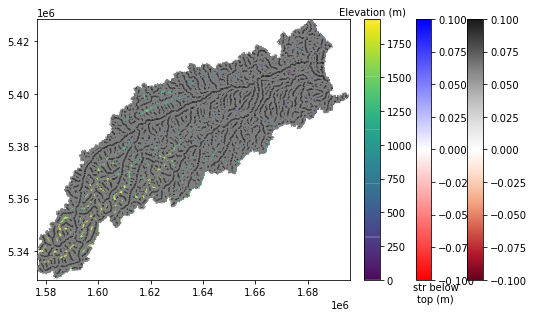

In [8]:
ngwf.plot_reaches_vs_model('all')

In [10]:
# this fails with pickle: obj._swn=swn in from_swn_flopy, but not part of pickle
ngwf.set_reach_slope(method='top_len')

ValueError: top_len not in ['auto', 'zcoord_ab', 'grid_top']

In [11]:
# https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-sfr.html?highlight=ustrf#block-packagedata
# started from sagehen example, tweaked
# can do ngwf.default_packagedata() now?
d={'rwid':10.0,'man':0.04,'ustrf':1.0,'ndv': 0}
for k in ["man", "rwid"]:
    ngwf.reaches[k]=d[k]

# was taking much time to fail with no zcoord, now takes 1.2 sec
t0=time.time()
#zcoord_ab or grid_top
try:
    ngwf.set_reach_slope(method='zcoord_ab')
except:
    print(time.time()-t0)


In [12]:
ngwf.fix_reach_elevs(autoreach=True)

14089 changed in loop 1


(<swn.modflow._modelplot.ModelPlot at 0x2157236fc88>,
 <swn.modflow._modelplot.ModelPlot at 0x2158605bf88>)

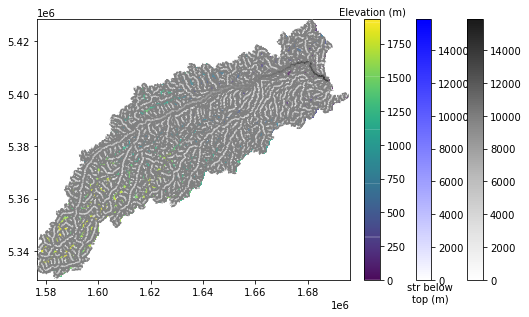

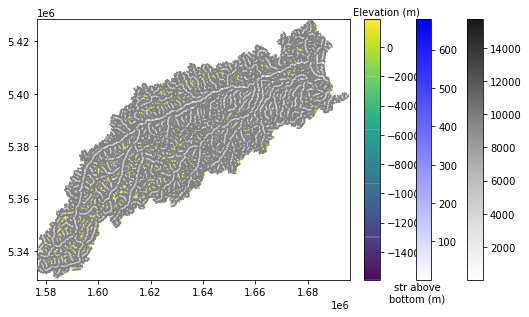

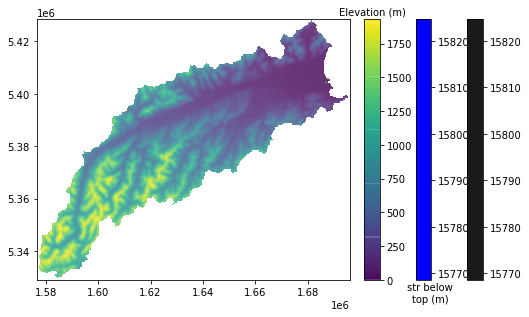

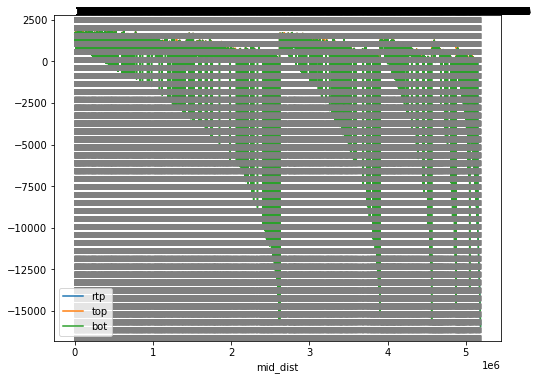

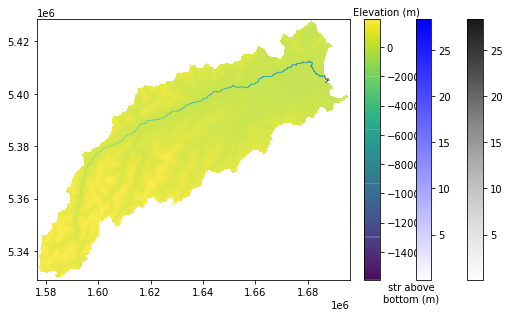

In [13]:
ngwf.plot_reaches_vs_model('all',plot_bottom=True)
ngwf.plot_reaches_vs_model(11024563,plot_bottom=True)

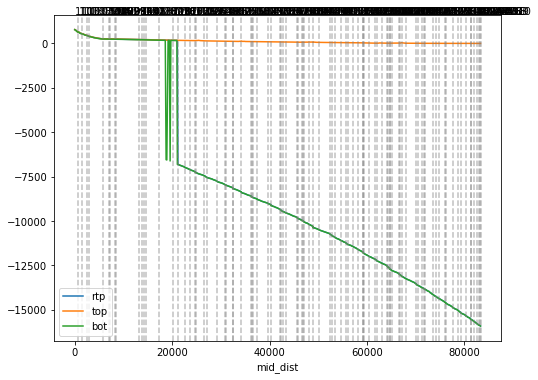

In [14]:
ngwf.plot_profile(11031777, downstream=True)

In [ ]:
    ngwf._swn.query(upstream=11024563)

In [ ]:
ngwf.reaches.loc[ngwf.reaches.segnum==13058095]

In [ ]:
ngwf.reaches.rtp.max()

In [ ]:
1--1

In [ ]:
ngwf.fix_reach_elevs()

In [ ]:
top=ngwf.model.dis.top.array
botm=ngwf.model.dis.botm.array

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(top)
plt.colorbar()

In [ ]:
f=ngwf.model.dis.top.get_file_entry().split("'")[1]
fpth=os.path.join(sim_ws+'_sfr',f)
np.savetxt(fpth,top)

In [ ]:
for b in range(0,botm.shape[0]):
    f=ngwf.model.dis.botm[b].fname
    fpth=os.path.join(sim_ws+'_sfr',f)
    np.savetxt(fpth,botm[b])

In [ ]:
ngwf.set_reach_data_from_array('rhk',gwf.npf.k.array[0])

In [ ]:
n.segments.to_csv(os.path.join(sim_ws+'_sfr',model_name+'_znseg_mf6rch.csv'))

In [ ]:
mask=[s for s in n.segments.index if (len(n.segments.loc[s,'from_segnums'])==0) & (n.segments.loc[s,'to_segnum']==0)]

In [ ]:
len(mask)

In [ ]:
n.segments.drop(mask,inplace=True)

In [ ]:


# There are two methods to format the PACKAGEDATA:
ngwf.flopy_packagedata
ngwf.write_packagedata(os.path.join(sim_ws+'_sfr',model_name+'.sfr.reach.dat'))

#Similar with CONNECTIONDATA:
ngwf.flopy_connectiondata
ngwf.write_connectiondata(os.path.join(sim_ws+'_sfr',model_name+'.sfr.connection.dat'))


In [ ]:
sfr=flopy.mf6.ModflowGwfsfr(gwf,packagedata={'filename':model_name+'.sfr.reach.dat'},
                            connectiondata={'filename':model_name+'.sfr.connection.dat'},
                           nreaches=len(ngwf.reaches),budget_filerecord=model_name + "_sfr.bud",
                            save_flows=True,unit_conversion=86400)
#gwf.register_package(sfr)
sfr.write()

In [ ]:
ngwf.reaches.loc[1,:]

In [ ]:

ngwf.plot_reaches_vs_model(13058096)

In [ ]:
gwf.write()

In [ ]:
help(ngwf)

# write shapefile, but not sfr info from grid intersection

In [ ]:
swn.file.gdf_to_shapefile(n.segments, 'segments.shp')